# **Feed Forward Neural Network**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'
# pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [20]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **FFNN Model**

In [9]:
def build_model(audio_features,
                hidden_layers,
                learning_rate,
                dropout_rate,
                regularizer_val,
                output_units=20
                ):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(audio_features.shape[1],), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          kernel_regularizer=tf.keras.regularizers.l2(regularizer_val),
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_testingtuning.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
def build_and_train_models(model_configs, train_features, train_y, val_features, val_y, train_results, val_results, val_scores, epochs=100, batch_size=32):
    """
    Build, train, and evaluate multiple models based on configurations provided in model_configs.

    Parameters:
    - model_configs: Dictionary where each key is a model name and the value is a config dictionary for that model.
    - train_features: Training features (e.g., mel spectrograms + MFCC).
    - train_y: Training labels.
    - val_features: Validation features (e.g., mel spectrograms + MFCC).
    - val_y: Validation labels.
    - train_results: Dictionary to store training results (e.g., accuracy).
    - val_results: Dictionary to store validation results (e.g., accuracy).
    - val_scores: Dictionary to store validation metrics like precision, recall, etc.
    - epochs: Number of epochs to train each model.
    - batch_size: Batch size for training.

    Returns:
    - None (modifies train_results, val_results, and val_scores in place).
    """

    for model_name, config in model_configs.items():
        print(f"Building and training {model_name}...")

        # Unpack the configuration for each model
        learning_rate = config.get('learning_rate')
        dropout_rate = config.get('dropout_rate')
        hidden_layers = config.get('hidden_layers')
        regularizer_val = config.get('regularizer_val')

        # Build the model
        model = build_model(
            audio_features=train_features,
            hidden_layers=hidden_layers,
            learning_rate=learning_rate,
            dropout_rate=dropout_rate,
            regularizer_val=regularizer_val
        )

        # Train the model
        history = model.fit(
            x=train_features,
            y=train_y,
            epochs=epochs,
            validation_data=(val_features, val_y),
            batch_size=batch_size,
            verbose=1
        )

        # Visualize training history
        visualize(history, model_name)

        # Evaluate model on training data
        train_yhat = model.predict(train_features)
        train_yhat_result = np.argmax(train_yhat, axis=-1)
        train_results[model_name] = model.evaluate(train_features, train_y)[-1]

        # Evaluate model on validation data
        val_yhat = model.predict(val_features)
        val_yhat_result = np.argmax(val_yhat, axis=-1)
        val_results[model_name] = model.evaluate(val_features, val_y)[-1]

        # Store validation scores (like accuracy, precision, recall, etc.)
        val_scores[model_name] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

        print(f"Completed training and evaluation for {model_name}.\n")

In [29]:
model_configs = {
    'model_1': {
        'hidden_layers': [128, 64, 32],
        'learning_rate': 0.0001,
        'dropout_rate': 0.3,
        'regularizer_val': 0.0015
    },
    'model_2': {
        'hidden_layers': [256, 128, 64],
        'learning_rate': 0.0001,
        'dropout_rate': 0.4,
        'regularizer_val': 0.002
    },
    'model_3': {
        'hidden_layers': [128, 64, 64],
        'learning_rate': 0.00001,
        'dropout_rate': 0.5,
        'regularizer_val': 0.0005
    },
    'model_4': {
        'hidden_layers': [128, 128, 64],
        'learning_rate': 0.00003,
        'dropout_rate': 0.4,
        'regularizer_val': 0.0001
    },
    'model_5': {
        'hidden_layers': [64, 64, 32],
        'learning_rate': 0.0001,
        'dropout_rate': 0.4,
        'regularizer_val': 0.002
    },
    'model_6': {
        'hidden_layers': [256, 128],
        'learning_rate': 0.0001,
        'dropout_rate': 0.4,
        'regularizer_val': 0.0012
    }
}


In [30]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs, Chroma

In [16]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['melspectrogram']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(5278, 41440)

In [17]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['melspectrogram']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(1350, 41440)

Building and training model_1...
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.1435 - loss: 4.0313 - val_accuracy: 0.4104 - val_loss: 2.4774
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3184 - loss: 3.0454 - val_accuracy: 0.5104 - val_loss: 2.2641
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3623 - loss: 2.8496 - val_accuracy: 0.5600 - val_loss: 2.1574
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4316 - loss: 2.6282 - val_accuracy: 0.5993 - val_loss: 2.0304
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4639 - loss: 2.4139 - val_accuracy: 0.5719 - val_loss: 2.0083
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5093 - loss: 2.2246 - val_accuracy: 0.6281 - val_loss: 1.8963
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5535 - loss: 2.1251 - val_accuracy: 0.6252 - val_loss: 1.8540
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

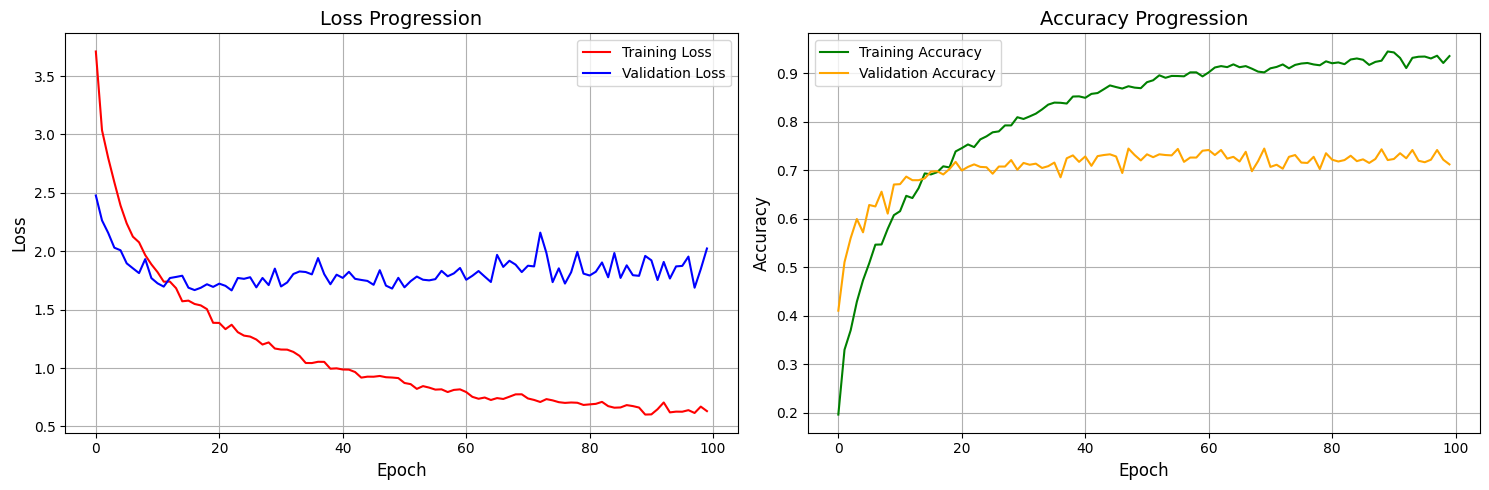

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9987 - loss: 0.4092
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7192 - loss: 1.9818
Validation classification Report 

              precision    recall  f1-score   support

           0       0.70      0.77      0.74       114
           1       0.54      0.45      0.49       141
           2       0.78      0.77      0.78       271
           3       0.87      1.00      0.93        90
           4       0.75      0.50      0.60        18
           5       0.69      0.60      0.64        15
           6       0.28      0.48      0.35        23
           7       0.95      0.95      0.95        44
           8       0.80      0.40      0.53        50
           9       0.81      0.90      0.85        49
          10       0.82      0.83      0.82        48
          11       0.79      0.24      0.37        46
          12       0.78      0.72 

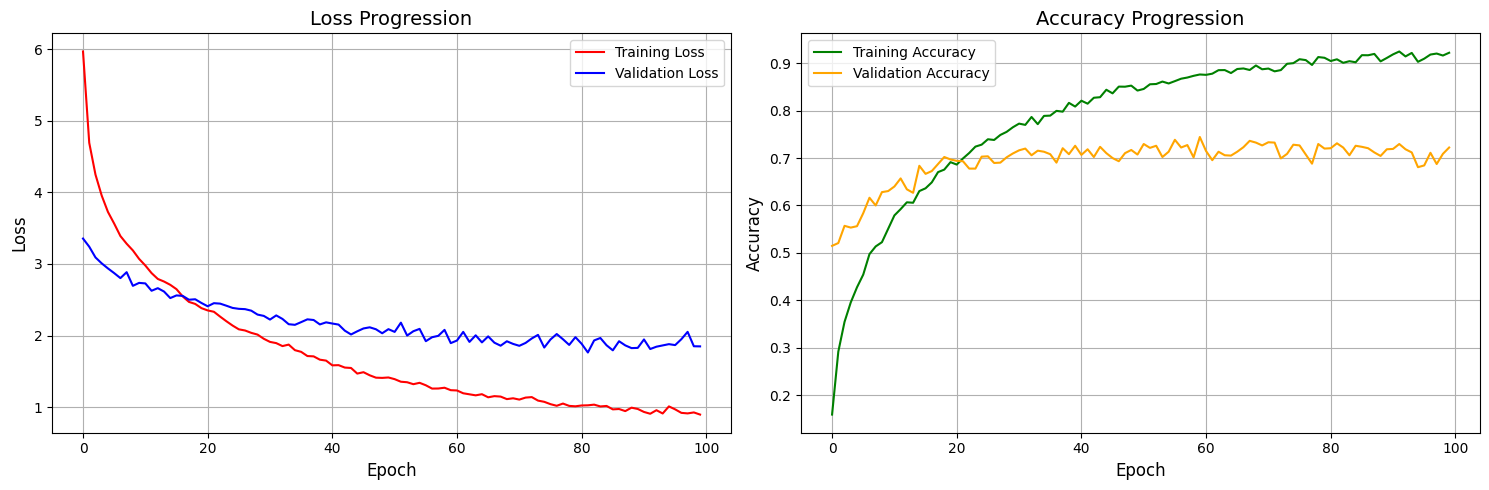

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9932 - loss: 0.6685
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7287 - loss: 1.8510
Validation classification Report 

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       114
           1       0.56      0.55      0.55       141
           2       0.79      0.75      0.77       271
           3       0.83      1.00      0.91        90
           4       1.00      0.33      0.50        18
           5       0.00      0.00      0.00        15
           6       0.47      0.35      0.40        23
           7       1.00      0.98      0.99        44
           8       0.44      0.70      0.54        50
           9       0.91      0.88      0.90        49
          10       0.90      0.77      0.83        48
          11       0.82      0.50      0.62        46
          12       0.80      0.74 

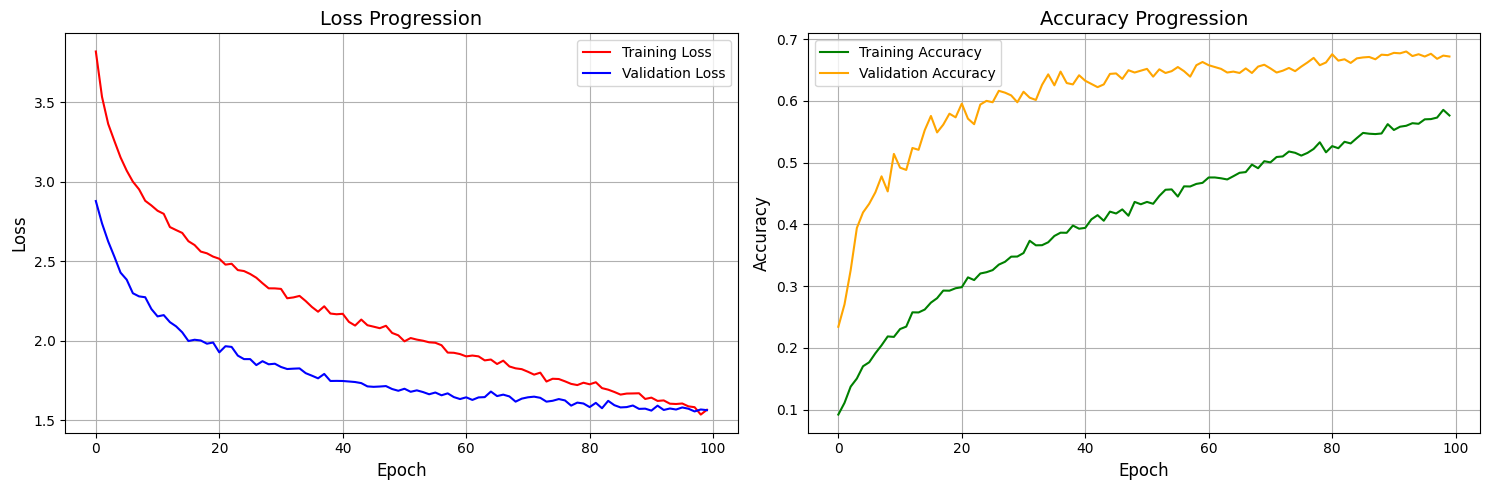

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8990 - loss: 0.8254
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6755 - loss: 1.5643
Validation classification Report 

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       114
           1       0.57      0.50      0.53       141
           2       0.71      0.85      0.77       271
           3       0.85      0.99      0.91        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.25      0.09      0.13        23
           7       1.00      1.00      1.00        44
           8       0.70      0.38      0.49        50
           9       0.95      0.84      0.89        49
          10       0.91      0.81      0.86        48
          11       0.00      0.00      0.00        46
          12       0.63      0.80 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1162 - loss: 3.5207 - val_accuracy: 0.3689 - val_loss: 2.2341
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1992 - loss: 2.9097 - val_accuracy: 0.5281 - val_loss: 1.8926
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2678 - loss: 2.5857 - val_accuracy: 0.5459 - val_loss: 1.7209
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3199 - loss: 2.3672 - val_accuracy: 0.5956 - val_loss: 1.5375
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3560 - loss: 2.2084 - val_accuracy: 0.6444 - val_loss: 1.3822
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4071 - loss: 2.0817 - val_accuracy: 0.6615 - val_loss: 1.3563
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4342 - loss: 1.9469 - val_accuracy: 0.6489 - val_loss: 1.3739
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4456 - loss: 1.9176 - val_acc

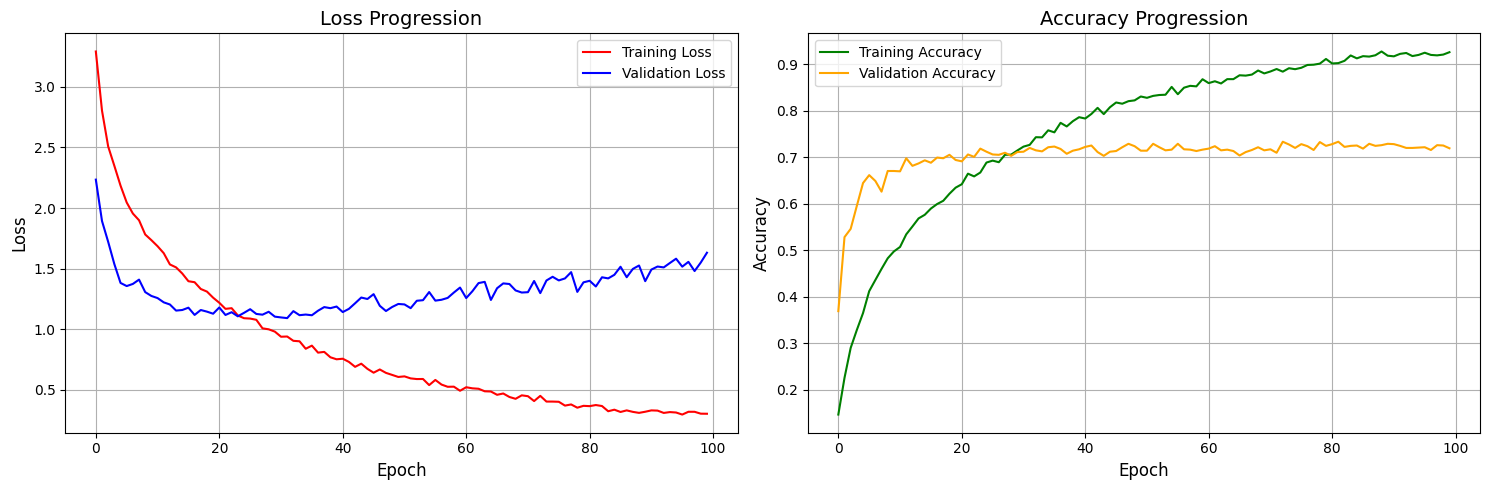

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9992 - loss: 0.0614
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7308 - loss: 1.6189
Validation classification Report 

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       114
           1       0.61      0.46      0.52       141
           2       0.76      0.82      0.79       271
           3       0.86      1.00      0.92        90
           4       0.78      0.39      0.52        18
           5       0.64      0.60      0.62        15
           6       0.30      0.39      0.34        23
           7       0.98      1.00      0.99        44
           8       0.66      0.46      0.54        50
           9       0.80      0.92      0.86        49
          10       0.86      0.77      0.81        48
          11       0.87      0.43      0.58        46
          12       0.66      0.74 

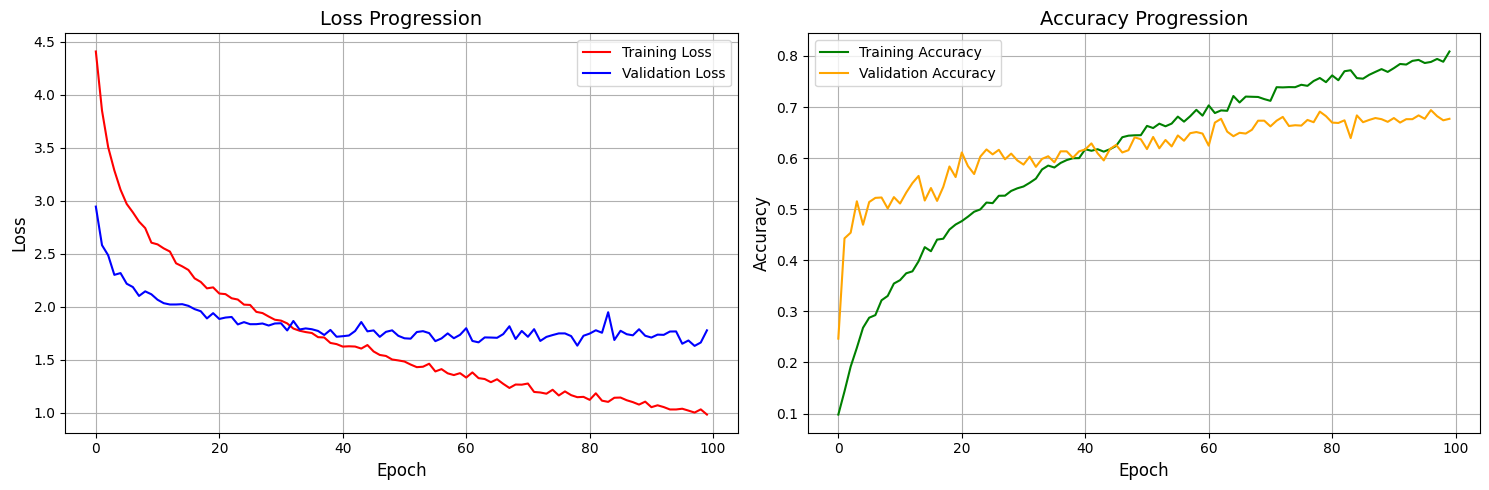

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9520 - loss: 0.5442
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6750 - loss: 1.8170
Validation classification Report 

              precision    recall  f1-score   support

           0       0.69      0.66      0.68       114
           1       0.66      0.44      0.53       141
           2       0.74      0.82      0.78       271
           3       0.90      0.99      0.94        90
           4       0.14      0.06      0.08        18
           5       0.40      0.40      0.40        15
           6       0.14      0.17      0.16        23
           7       1.00      0.95      0.98        44
           8       0.49      0.62      0.55        50
           9       0.77      0.94      0.84        49
          10       0.86      0.67      0.75        48
          11       0.43      0.07      0.11        46
          12       0.75      0.78 

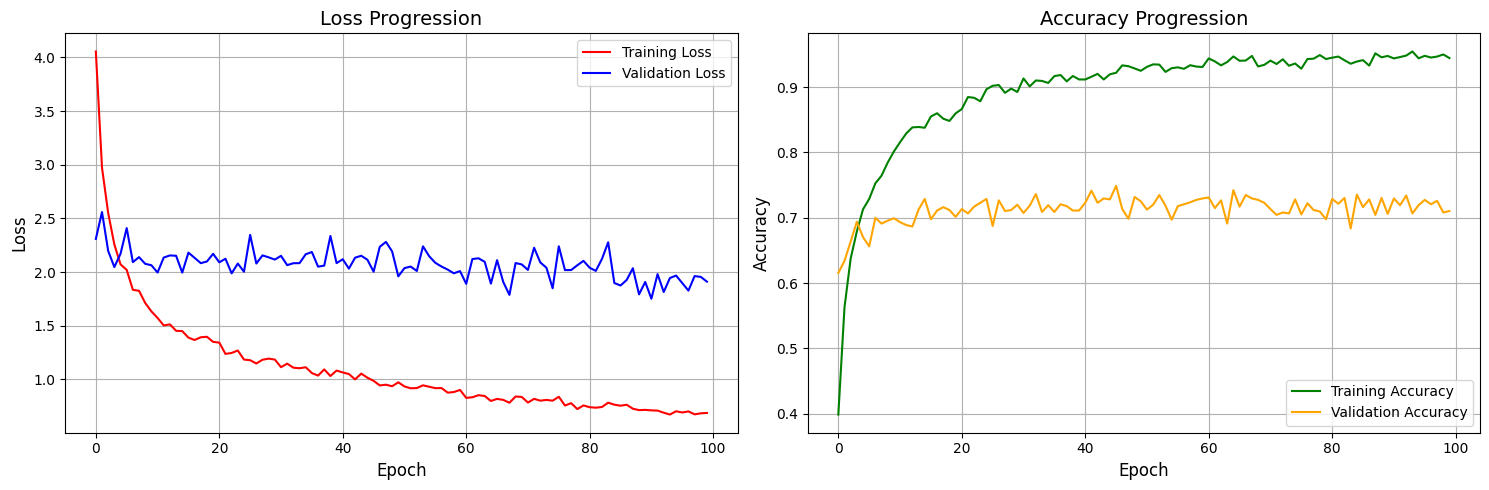

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.5216
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7194 - loss: 1.9151
Validation classification Report 

              precision    recall  f1-score   support

           0       0.79      0.59      0.67       114
           1       0.54      0.60      0.57       141
           2       0.69      0.77      0.73       271
           3       0.89      1.00      0.94        90
           4       0.85      0.61      0.71        18
           5       0.46      0.40      0.43        15
           6       0.27      0.48      0.34        23
           7       1.00      0.95      0.98        44
           8       0.75      0.36      0.49        50
           9       0.71      0.94      0.81        49
          10       0.92      0.75      0.83        48
          11       0.74      0.61      0.67        46
          12       0.73      0.70 

In [31]:
# Build, train, and evaluate models
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

build_and_train_models(
    model_configs=model_configs,
    train_features=training_features,
    train_y=train_y,
    val_features=validation_features,
    val_y=val_y,
    train_results=train_results,
    val_results=val_results,
    val_scores=val_scores,
    epochs=100,
    batch_size=32
)

Checking the class weights impact on the best model

In [33]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_y),
                                                  y=train_y)
class_weight_dict = dict(enumerate(class_weights))

config = model_configs['model_2']

# Build model
model = build_model(audio_features=training_features,
                    hidden_layers=config['hidden_layers'],
                    learning_rate=config['learning_rate'],
                    dropout_rate=config['dropout_rate'],
                    regularizer_val=config['regularizer_val'])

In [34]:
history = model.fit(training_features, train_y,
                    validation_data=(validation_features, val_y),
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    verbose=1)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.1007 - loss: 6.7584 - val_accuracy: 0.4489 - val_loss: 3.5596
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2004 - loss: 5.5057 - val_accuracy: 0.5141 - val_loss: 3.2744
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2420 - loss: 5.0212 - val_accuracy: 0.5444 - val_loss: 3.2780
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3179 - loss: 4.4816 - val_accuracy: 0.5793 - val_loss: 3.0797
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3287 - loss: 4.2933 - val_accuracy: 0.5733 - val_loss: 3.0858
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3512 - loss: 4.1274 - val_accuracy: 0.5904 - val_loss: 3.0150
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4013 - loss: 4.0048 - val_accuracy: 0.6185 - val_loss: 2.9363
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4018 - loss: 3.8212 - val_acc

In [35]:
# Evaluate model on training data
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['model_2_balance'] = model.evaluate(training_features, train_y)[-1]

# Evaluate model on validation data
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['model_2_balance'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9452 - loss: 0.9347
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7132 - loss: 1.8439


## Review all the results

In [36]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,model_1,0.998,0.712
1,model_2,0.995,0.722
6,model_2_balance,0.946,0.717
2,model_3,0.892,0.672
3,model_4,0.999,0.719
4,model_5,0.951,0.677
5,model_6,0.997,0.710


In [37]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

  Features  F1_Score  AUC_Score
0  model_1     0.704      0.945
1  model_2     0.720      0.956
2  model_3     0.635      0.930
3  model_4     0.712      0.948
4  model_5     0.668      0.945
5  model_6     0.703      0.961
